# ChE 696 Final Project: Modeling explosive percolation based on local rules
Shannon Moran
Fall 2018

This is my final project for the ChE 696 Special Topics Class "Fractals and Percolation" with Prof. Bob Ziff.

I'm replicating the following paper (found [here](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.97.020301)):
> Alexander J. Trevelyan, Georgios Tsekenis, and Eric I. Corwin. "Degree product rule tempers explosive percolation in the absence of global information." Physical Review E 97, 020301(R) (2018).

This paper implement three types of growth process for graphs:
* ER: Erdos-Renyi, a random graph generation
* AP: Achlioptas growth process, a competitive rule based on cluster sizes of the potential new cluster 
* DPR: Degree product rule, a local competitive rule based on the degrees of the component nodes of each proposed edge

Here, I've implemented algorithms for generating each and clustering algorithms (Newman-Ziff) to analyze them. My ability to derive critical exponents was limited by the scale of the systems I was limited to by time and implementation. 

In [ ]:
# Auto-reloads external files any changes are automatically reflected
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import random
from tqdm import tqdm,tqdm_notebook
import math

import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Set up network generation and clustering analysis algorithms

In [65]:
class NetworkGeneration(object):
    def __init__(self,N,p,process_name,m=0):
        self.N = N # nodes, 3.6e5 in paper
        self.p = p
        self.m = m
        self.t = N*p # edges to add
        self.ptr = np.nan*np.ones(int(N)) # ptr empty array for NZ algorithm
        self.N_list = list(np.arange(self.N).astype(int))
        self.process = process_name
    
    def build(self):
        if self.process=='ER': self.ER()
        elif self.process=='AP': self.AP()
        elif self.process=='DPR': self.DPR()
        else: print('build with a valid process')
            
    def calculate_edge_product(self,G,edge_tuple):
        return (G.degree[edge_tuple[0]]+1)*(G.degree[edge_tuple[1]]+1)
            
    def calculate_edge_cluster_sum(self,edge_tuple):
        return sum([self.NZ_root_value(int(node)) for node in edge_tuple])
    
    def ER(self):
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an ER network")
        while len(G.edges)<self.t:
            proposed_edge = (np.random.choice(self.N_list,2,replace=False))
            G.add_edge(proposed_edge[0],proposed_edge[1])
            self.NZ_update(proposed_edge)
            C.append(-np.amin(self.ptr[np.where(np.logical_not(np.isnan(self.ptr)))])/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G
            
    def DPR(self):
        # DPR: goes to smallest product of the degrees of connection
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building a DPR network")
        while len(G.edges)<self.t:
            proposed_edges = ([np.random.choice(self.N_list,2,replace=False) for _ in range(self.m)])
            proposed_edge_weights = [self.calculate_edge_product(G,edge_tuple) for edge_tuple in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            self.NZ_update(winning_edge)
            C.append(-np.amin(self.ptr[np.where(np.logical_not(np.isnan(self.ptr)))])/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G

    def find_root(self,node):
        if self.ptr[int(node)]<0: return int(node) # root of a tree
        elif math.isnan(self.ptr[int(node)]): return int(node) # solo node
        else: return self.find_root(int(self.ptr[int(node)])) # node points to a root, find root location

    def NZ_root_value(self,node):
        root = self.find_root(int(node))
        if math.isnan(self.ptr[int(root)]): return 1
        else: return int(-self.ptr[root])
        
    def NZ_update(self,nodes_added):
        roots = (self.find_root(nodes_added[0]),self.find_root(nodes_added[1]))
        if roots[0]==roots[1]: return
        
        # get cluster size at each root (NZ_root_value automatically calculates as 1 for solo)
        cluster_size = [self.NZ_root_value(root) for root in roots]
        if cluster_size==sorted(cluster_size): smaller_node=nodes_added[0]; larger_node=nodes_added[1]
        else: smaller_node=nodes_added[1]; larger_node=nodes_added[0]
            
        # have nodes within the smaller cluster to point to the larger cluster
        smaller_root_loc = self.find_root(smaller_node)
        larger_root_loc = self.find_root(larger_node)
        np.place(self.ptr,(self.ptr==smaller_root_loc),larger_root_loc)
        
        # add the number of nodes in the smaller cluster to the larger cluster
        self.ptr[larger_root_loc] = -(self.NZ_root_value(larger_root_loc) + self.NZ_root_value(smaller_root_loc))
        
        # point the smaller root to the larger root
        self.ptr[smaller_root_loc] = larger_root_loc
    
    def AP(self):
        # AP: goes to smallest sum of clusters connected to each node
        C = []
        G = nx.Graph()
        G.add_nodes_from(np.arange(self.N))
        pbar = tqdm_notebook(total=(self.t),desc="Building an AP network")
        while len(G.edges)<self.t:
            proposed_edges = [np.random.choice(self.N_list,2,replace=False) for _ in range(self.m)]
            proposed_edge_weights = [self.calculate_edge_cluster_sum(edge) for edge in proposed_edges]
            winning_edge = proposed_edges[proposed_edge_weights.index(min(proposed_edge_weights))]
            G.add_edge(winning_edge[0],winning_edge[1])
            self.NZ_update(winning_edge)
            C.append(-np.amin(self.ptr[np.where(np.logical_not(np.isnan(self.ptr)))])/self.N)
            pbar.update(len(G.edges))
        pbar.close()
        self.C = C
        self.G = G

## Figure 1: Network structure

In [74]:
N = 1e4 # nodes, 3.6e5 in paper
p = 1

test_ER = NetworkGeneration(N,p,'ER')
test_ER.build()

test_DPR = NetworkGeneration(N,p,'DPR',m=2)
test_DPR.build()

test_AP = NetworkGeneration(N,p,'AP',m=2)
test_AP.build()

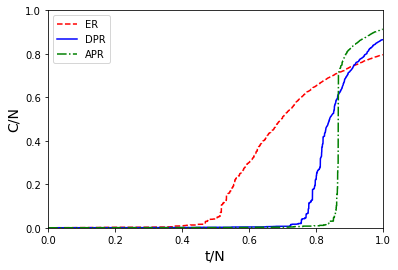

In [100]:
x = int(N-2)
t_range = (np.arange(N*p+1)/N)[:x]

plt.plot(t_range,test_ER.C[:x],'r--',label='ER')
plt.plot(t_range,test_DPR.C[:x],'b-',label='DPR')
plt.plot(t_range,test_AP.C[:x],'g-.',label='APR')
# plt.plot(t_range,test_AP.C,'g-.')
plt.ylabel('C/N')
plt.xlabel('t/N')
plt.ylim(0.0,1.0)
plt.xlim(0.0,1.0)
plt.legend()
plt.show()

## Figure 2: "Largest jump" order parameter
Problem: The paper doesn't actually say what $p$ value this is for.

I'm going to assume it's $p=1$. I'm also going to use a binary search to quickly find the largest cluster size jump in this simulations I ran above.

In [76]:
def binary_search(G,C,start,end,largest_jump):
    # x-values
    midpoint = int((end+start)/2)
    
    # y-values
    head = C[int(start)]
    mid = C[midpoint]
    tail = C[int(end)]
        
    # If start and end are only one step removed from on another, then search is complete
    if abs(end-start)==1:
        if (tail-head)>largest_jump: largest_jump = (tail-head)
        return largest_jump
    # Check which side of the midpoint the largest jump is on
    elif (mid-head)>(tail-mid):
        if (mid-head)>(len(G.nodes)*0.01):
            largest_jump = (mid-head)
            return binary_search(G,C,int(start),int(midpoint),largest_jump)
    elif (tail-mid)>(len(G.nodes)*0.01):
        largest_jump = (tail-mid)
        return binary_search(G,C,int(midpoint),int(end),largest_jump)
    return largest_jump

In [114]:
N_range = np.asarray([1e2,5e2,1e3,2.5e3,5e3,1e4])
p = 1.0

start = 0
F2_DPR_2_Cmax = []
F2_DPR_10_Cmax = []
F2_DPR_50_Cmax = []
F2_ER_Cmax = []

for N_test in N_range:
    N_test = round(N_test-1)
    end = N_test*p-1
    F2_ER = NetworkGeneration(N_test,p,'ER')
    F2_ER.build()
    F2_ER_Cmax.append(binary_search(F2_ER.G,[c*N_test for c in F2_ER.C],start,end,0)/N_test)
    F2_DPR_2 = NetworkGeneration(N_test,p,'DPR',m=2)
    F2_DPR_2.build()
    F2_DPR_2_Cmax.append(binary_search(F2_DPR_2.G,[c*N_test for c in F2_DPR_2.C],start,end,0)/N_test)
    F2_DPR_10 = NetworkGeneration(N_test,p,'DPR',m=10)
    F2_DPR_10.build()
    F2_DPR_10_Cmax.append(binary_search(F2_DPR_10.G,[c*N_test for c in F2_DPR_10.C],start,end,0)/N_test)
    F2_DPR_50 = NetworkGeneration(N_test,p,'DPR',m=50)
    F2_DPR_50.build()
    F2_DPR_50_Cmax.append(binary_search(F2_DPR_50.G,[c*N_test for c in F2_DPR_50.C],start,end,0)/N_test)

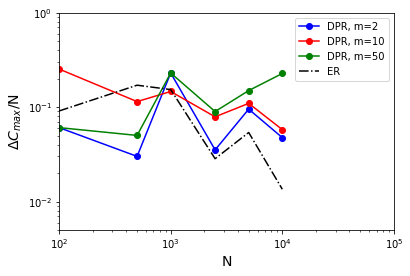

In [115]:
plt.loglog(N_range,F2_DPR_2_Cmax,'bo-',label='DPR, m=2')
plt.loglog(N_range,F2_DPR_10_Cmax,'ro-',label='DPR, m=10')
plt.loglog(N_range,F2_DPR_50_Cmax,'go-',label='DPR, m=50')
plt.loglog(N_range,F2_ER_Cmax,'k-.',label='ER')
plt.ylabel(r'${\Delta}C_{max}$/N')
plt.xlabel('N')
plt.ylim(5e-3,1e0)
plt.xlim(1e2,1e5)
plt.legend()
plt.show()

This plot is the right order of magnitude as that published in the paper, but is much noisier. This is because these systems need be sampled to get the critical behavior-- the randomness in the edge addition means each individual simulation is just one statistical event.

## Figure 3: Node degree distribution

In [ ]:
N = 1e4 # nodes, 1.7e4 in paper
p = 5 # provided by paper

F3_ER = NetworkGeneration(N,p,'ER')
F3_ER.build()

F3_DPR = NetworkGeneration(N,p,'DPR',m=2)
F3_DPR.build()

F3_AP = NetworkGeneration(N,p,'AP',m=2)
F3_AP.build()

In [85]:
bins = np.arange(17)
ER_hist,_ = np.histogram([d/2 for n, d in F3_ER.G.degree()],bins=bins)
DPR_hist,_ = np.histogram([d/2 for n, d in F3_DPR.G.degree()],bins=bins)
AP_hist,_ = np.histogram([d/2 for n, d in F3_AP.G.degree()],bins=bins)

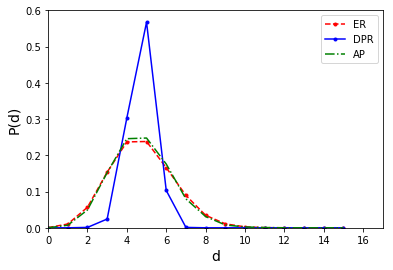

In [105]:
x = bins[:-1]
plt.plot(x,ER_hist/N,'r.--',label='ER')
plt.plot(x,DPR_hist/N,'b.-',label='DPR')
plt.plot(x,AP_hist/N,'g-.',label='AP')
plt.ylabel('P(d)')
plt.xlabel('d')
plt.ylim(0.0,0.6)
plt.xlim(0,17)
plt.legend()
plt.show()

## Figure 4: Critical behavior
In this case, they don't give me $m$! I've assumed it's $m=2$ for continuity with earlier graphs that were constant-$m$.

In [177]:
def mean_cluster_size_from_ptr(N,ptr):
    # feed in ptr as an array
    cluster_sizes = ptr[ptr<0]
    mean_cluster_size = sum([(s**2) for s in cluster_sizes])/N
    return mean_cluster_size

In [178]:
# N_range = np.asarray([1e2,2.5e2,5e2,7.5e2,1e3])
N_range = np.asarray([1e2,5e2,1e3,2.5e3,5e3,7.5e3,1e4])

# pc = 0.763
largest_cluster_a = []
average_cluster_size_a = []
largest_cluster_b = []
average_cluster_size_b = []
largest_cluster_c = []
average_cluster_size_c = []
for N_test in N_range:
    N_test = round(N_test-1)
    F4_DPR_c = NetworkGeneration(N_test,0.763,'DPR',m=2)
    F4_DPR_c.build()
    largest_cluster_c.append(max(F4_DPR_c.C))
    average_cluster_size_c.append(mean_cluster_size_from_ptr(N_test,F4_DPR_c.ptr))
    F4_DPR_a = NetworkGeneration(N_test,0.77,'DPR',m=2)
    F4_DPR_a.build()
    largest_cluster_a.append(max(F4_DPR_a.C))
    average_cluster_size_a.append(mean_cluster_size_from_ptr(N_test,F4_DPR_a.ptr))
    F4_DPR_b = NetworkGeneration(N_test,0.75,'DPR',m=2)
    F4_DPR_b.build()
    largest_cluster_b.append(max(F4_DPR_b.C))
    average_cluster_size_b.append(mean_cluster_size_from_ptr(N_test,F4_DPR_b.ptr))

/Users/shannon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


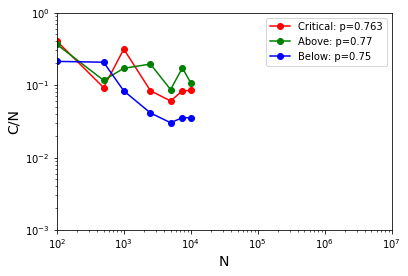

In [179]:
plt.loglog(N_range,largest_cluster_c,'ro-',label='Critical: p=0.763')
plt.loglog(N_range,largest_cluster_a,'go-',label='Above: p=0.77')
plt.loglog(N_range,largest_cluster_b,'bo-',label='Below: p=0.75')
plt.ylabel('C/N')
plt.xlabel('N')
plt.ylim(1e-3,1e0)
plt.xlim(1e2,1e7)
plt.legend()
plt.show()

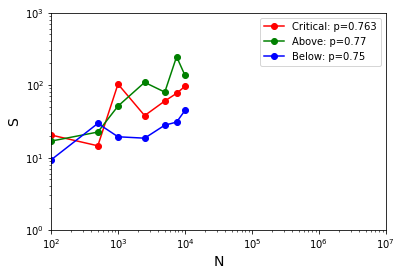

In [180]:
plt.loglog(N_range,average_cluster_size_c,'ro-',label='Critical: p=0.763')
plt.loglog(N_range,average_cluster_size_a,'go-',label='Above: p=0.77')
plt.loglog(N_range,average_cluster_size_b,'bo-',label='Below: p=0.75')
plt.ylabel('S')
plt.xlabel('N')
plt.ylim(1e0,1e3)
plt.xlim(1e2,1e7)
plt.legend()
plt.show()